In [1]:
# (C) 2021, முத்து அண்ணாமலை <ezhillang@gmail.com>
# இந்த நிரல் பொதுவெளி உரிமத்தில் வைக்கப்படுகிறது.
# இந்த நிரல் வழி ஏற்படும் எந்த விளைவிற்கும் ஆசிரியை
# பொருப்பு ஏற்றுக்கொள்ளமாட்டார்.
# 
# Code adapted from https://github.com/javaidnabi31/Multi-class-with-imbalanced-dataset-classification/blob/master/20-news-group-classification.ipynb
import pandas as pd
import numpy as np
import numpy.matlib
import pickle
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
# For reproducibility
np.random.seed(1237)

In [2]:
!pip install --upgrade open-tamil

In [3]:
பால்_வகை = ["அறத்துப்பால்","பொருட்பால்","காமத்துப்பால்"]
பால்_எண்ணிக்கை = len(பால்_வகை)

import tamil
import kural
import re
பால் = {}
பால்["அறத்துப்பால்"] = []
பால்["பொருட்பால்"] = []
பால்["காமத்துப்பால்"] = []

மாதிரி = re.compile('\n|\.')
திருக்குறள்_db = kural.Thirukkural()
for பாவகை in பால்_வகை:
    for குறள் in திருக்குறள்_db.get_kurals_from_pal(பாவகை):
        பால்[பாவகை].append( re.sub(மாதிரி,'',குறள்.ta) )

from pprint import pprint
#pprint(பால்)

for பா_பெயர், பா_மதிப்பு in பால்.items():
    print(பா_பெயர்,len(பா_மதிப்பு))


அறத்துப்பால் 380
பொருட்பால் 700
காமத்துப்பால் 250


In [4]:
print("குறள் மொத்த எண்ணிக்கை",sum([len(பா_மதிப்பு) for பா_பெயர், பா_மதிப்பு in பால்.items()]))

குறள் மொத்த எண்ணிக்கை 1330


In [18]:
vocab_size = 247
vectorized_size = 40
batch_size = 100
num_epochs = 30
train_size_per_class=200 #150 என்று மாற்றினால் என்ன ஆகிறது? பாருங்கள்.
train_size = train_size_per_class*பால்_எண்ணிக்கை

In [19]:
#build vocabulary and text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_features = vocab_size
vectorize_layer = TextVectorization(    
    output_sequence_length=None,
    max_tokens=max_features,
    output_mode="int",    
)

எழுத்து = []
for குறள் in திருக்குறள்_db.iterator():
    எழுத்து.extend( tamil.utf8.get_letters(குறள்[1]) )
vectorize_layer.adapt( np.array( எழுத்து ) )

In [20]:
#குறட்பாக்களை எண்களாக மாற்றிடலாம். 40 இடங்கள் கொண்ட அணியாக ஆக்கிடலாம்;
#கூடுதலாக 40-க்கு மேல் உள்ளதை அழித்தும், குறைவாக இருந்தால் அவற்றிற்கு 0-சேர்த்தும் 
#இணைத்திடலாம்.

இடம்சூட்டு_சார்பு = lambda pos: np.eye(பால்_எண்ணிக்கை)[pos,:]
பால்_அணி = {}
பால்_வகை_குறியீடு = {}
இடம்=0
for பா_பெயர், பா_மதிப்பு in பால்.items():
    val = np.zeros((40))
    பால்_அணி[பா_பெயர்] = []
    for குறள் in பா_மதிப்பு:
        result = vectorize_layer(np.array(tamil.utf8.get_letters(குறள்))).numpy().squeeze()
        கடைசி = min(len(result),vectorized_size)
        val[:கடைசி]=result[:கடைசி]
        பால்_அணி[பா_பெயர்].append( val )
    பால்_வகை_குறியீடு[பா_பெயர்] = இடம்சூட்டு_சார்பு(இடம்)
    இடம் += 1
    
#pprint(பால்_அணி[பா_பெயர்])
for பா_பெயர், பா_மதிப்பு in பால்.items():
    print(பா_பெயர்,np.array(பால்_அணி[பா_பெயர்]).shape)
pprint(பால்_வகை_குறியீடு)


அறத்துப்பால் (380, 40)
பொருட்பால் (700, 40)
காமத்துப்பால் (250, 40)
{'அறத்துப்பால்': array([1., 0., 0.]),
 'காமத்துப்பால்': array([0., 0., 1.]),
 'பொருட்பால்': array([0., 1., 0.])}


In [21]:
# பயில்விக்கும் தரவுகளையும் பரிசோதிக்கும் தரவுகளையும் தயார்படுத்தவும்.
x_பயில்,y_பயில் = [],[]
x_பரிசோதி,y_பரிசோதி = [],[]

for பா_பெயர், பா_மதிப்பு in பால்.items():
    # முதல் @train_size_per_class@ ,இங்கு 200, மாரிலி அளவு சேர்க்கப்படுகிறது
    x_பயில்.append( np.array(பால்_அணி[பா_பெயர்][:train_size_per_class]) )
    y_பயில்.append( np.matlib.repmat( பால்_வகை_குறியீடு[பா_பெயர்], train_size_per_class,1) )
    
    x_பரிசோதி.append( np.array(பால்_அணி[பா_பெயர்][train_size_per_class:]) )
    y_பரிசோதி.append( numpy.matlib.repmat( பால்_வகை_குறியீடு[பா_பெயர்], len(x_பரிசோதி[-1]),1) )

x_பயில் = np.concatenate(x_பயில்)
y_பயில் = np.concatenate(y_பயில்)
x_பரிசோதி = np.concatenate(x_பரிசோதி)
y_பரிசோதி = np.concatenate(y_பரிசோதி)

if False: #swap?
  x_பயில்,x_பரிசோதி=x_பரிசோதி,x_பயில்
  y_பயில்,y_பரிசோதி=y_பரிசோதி,y_பயில்

In [22]:
print(x_பயில்.shape)
print(y_பயில்.shape)
print(x_பரிசோதி.shape)
print(y_பரிசோதி.shape)

(600, 40)
(600, 3)
(730, 40)
(730, 3)


In [23]:
#பால் பகுப்பாய்வு மாதிரி
model = Sequential()
model.add(Dense(8, input_shape=(vectorized_size,)))
model.add(Activation('relu'))
#model.add(Dropout(0.3))
model.add(Dense(16)) #12 என்பதையும் பயன்படுத்தி பார்க்கலாம்
model.add(Activation('relu'))
#model.add(Dropout(0.3))
model.add(Dense(பால்_எண்ணிக்கை))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 328       
                                                                 
 activation_3 (Activation)   (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 16)                144       
                                                                 
 activation_4 (Activation)   (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 51        
                                                                 
 activation_5 (Activation)   (None, 3)                 0         
                                                                 
Total params: 523
Trainable params: 523
Non-trainable 

In [24]:
num_epochs = 15
batch_size = 64
history = model.fit(x_பயில், y_பயில்,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    validation_split=0.2) #0.5

Epoch 1/15
8/8 - 1s - loss: 54.4702 - accuracy: 0.4167 - val_loss: 34.8401 - val_accuracy: 0.0000e+00 - 737ms/epoch - 92ms/step
Epoch 2/15
8/8 - 0s - loss: 43.9025 - accuracy: 0.4167 - val_loss: 24.9466 - val_accuracy: 0.0000e+00 - 35ms/epoch - 4ms/step
Epoch 3/15
8/8 - 0s - loss: 34.6799 - accuracy: 0.4167 - val_loss: 16.4474 - val_accuracy: 0.0000e+00 - 33ms/epoch - 4ms/step
Epoch 4/15
8/8 - 0s - loss: 26.7040 - accuracy: 0.2583 - val_loss: 10.3738 - val_accuracy: 0.0000e+00 - 33ms/epoch - 4ms/step
Epoch 5/15
8/8 - 0s - loss: 19.7624 - accuracy: 0.4167 - val_loss: 6.2446 - val_accuracy: 0.0000e+00 - 28ms/epoch - 4ms/step
Epoch 6/15
8/8 - 0s - loss: 11.7052 - accuracy: 0.2208 - val_loss: 2.2058 - val_accuracy: 0.0000e+00 - 31ms/epoch - 4ms/step
Epoch 7/15
8/8 - 0s - loss: 4.6138 - accuracy: 0.4917 - val_loss: 0.4535 - val_accuracy: 1.0000 - 37ms/epoch - 5ms/step
Epoch 8/15
8/8 - 0s - loss: 0.7997 - accuracy: 0.7229 - val_loss: 0.1239 - val_accuracy: 1.0000 - 33ms/epoch - 4ms/step
Epoc

In [25]:
#indexes = np.random.choice(np.arange(len(பால்_அணி[பா_பெயர்])),replace=False,size=train_size_per_class)
#முதல் 200 குறட்பாக்களை கொண்டு பயில்விக்கலாம்.


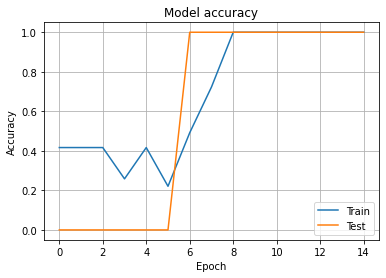

In [26]:
# accuracy, loss, validation curves
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

In [27]:
loss, acc = model.evaluate(x_பரிசோதி, y_பரிசோதி,
                       batch_size=batch_size, verbose=2)

print('Test accuracy:', acc)
print('Test loss:',loss)

12/12 - 0s - loss: 9.7661e-04 - accuracy: 1.0000 - 32ms/epoch - 3ms/step
Test accuracy: 1.0
Test loss: 0.0009766145376488566


In [28]:
# வரிசையற்றபடி பரிசோதிக்கும் தரவில் பகுப்பய்வை நிரல்படுத்திப்பார்த்தல்:
for _ in range(10):
    இடம் = np.random.choice(np.arange( len(x_பரிசோதி) ) )
    print(இடம்)
    prediction = model.predict(x_பரிசோதி[இடம்].reshape(1,40))
    print(prediction[0])
    predicted_label = பால்_வகை[np.argmax(prediction[0])]
    print(predicted_label,'actual=>',y_பரிசோதி[இடம்])
    print('மெய் விடை>> :' +  பால்_வகை[ np.argmax(y_பரிசோதி[இடம்]) ], '|',"பின்னல் விடை >> : " + predicted_label)

204
[1.0602131e-06 9.9996889e-01 3.0003897e-05]
பொருட்பால் actual=> [0. 1. 0.]
மெய் விடை>> :பொருட்பால் | பின்னல் விடை >> : பொருட்பால்
399
[1.0602131e-06 9.9996889e-01 3.0003897e-05]
பொருட்பால் actual=> [0. 1. 0.]
மெய் விடை>> :பொருட்பால் | பின்னல் விடை >> : பொருட்பால்
441
[1.0602131e-06 9.9996889e-01 3.0003897e-05]
பொருட்பால் actual=> [0. 1. 0.]
மெய் விடை>> :பொருட்பால் | பின்னல் விடை >> : பொருட்பால்
469
[1.0602131e-06 9.9996889e-01 3.0003897e-05]
பொருட்பால் actual=> [0. 1. 0.]
மெய் விடை>> :பொருட்பால் | பின்னல் விடை >> : பொருட்பால்
10
[9.9959117e-01 4.0117055e-04 7.6324632e-06]
அறத்துப்பால் actual=> [1. 0. 0.]
மெய் விடை>> :அறத்துப்பால் | பின்னல் விடை >> : அறத்துப்பால்
72
[9.9959117e-01 4.0117055e-04 7.6324632e-06]
அறத்துப்பால் actual=> [1. 0. 0.]
மெய் விடை>> :அறத்துப்பால் | பின்னல் விடை >> : அறத்துப்பால்
589
[1.0602131e-06 9.9996889e-01 3.0003897e-05]
பொருட்பால் actual=> [0. 1. 0.]
மெய் விடை>> :பொருட்பால் | பின்னல் விடை >> : பொருட்பால்
352
[1.0602131e-06 9.9996889e-01 3.0003897e-05]
பொரு

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Normalized confusion matrix


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2949 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2993 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2980 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3021 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3009 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2986 missing from current font.
  font.set_text(s

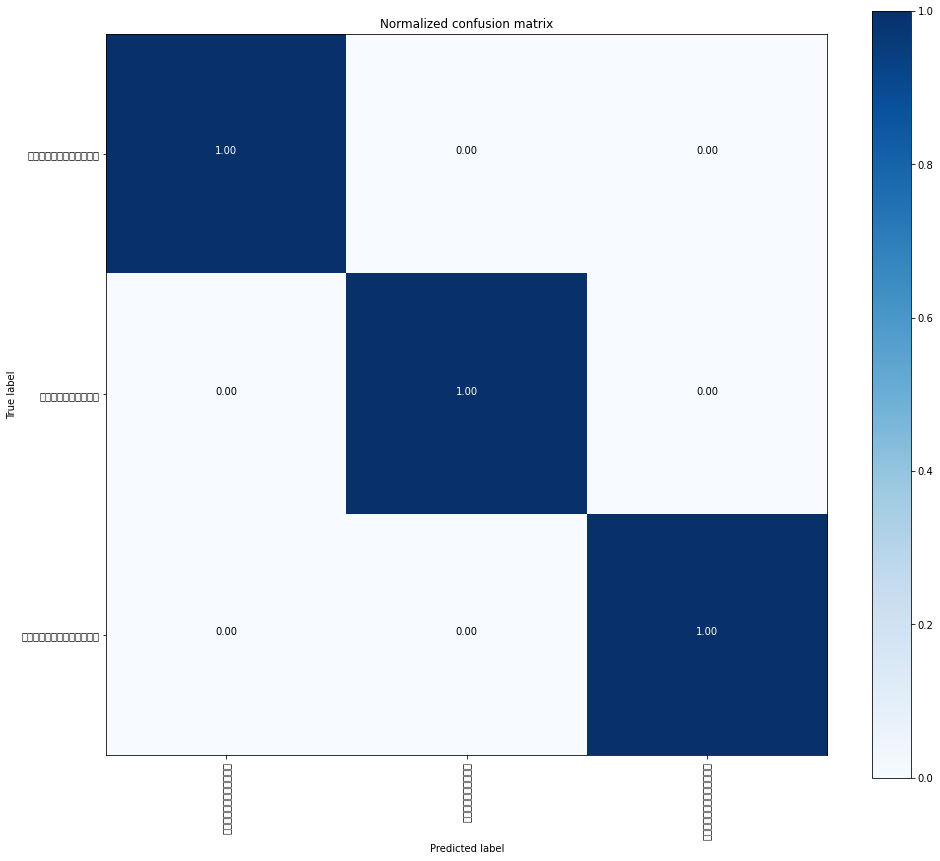

In [29]:
y_பின்னல்_விடை = model.predict(x_பரிசோதி)
cnf_matrix = confusion_matrix(np.argmax(y_பரிசோதி, axis=1), np.argmax(y_பின்னல்_விடை, axis=1))

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)    

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(பால்_வகை), normalize=True,
                      title='Normalized confusion matrix')
plt.show()
